In [1]:
#!pip uninstall xgboost
!pip install xgboost==0.80

You should consider upgrading via the '/Users/ezequiellopez/_projects/UNED-PhD/src/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Methodology
-------

1. **input** Select input data => will be preprocessed and loaded as a FeatureExtractor object
2. **split** Split the data using class method and providing size and random_state (it preserves whole comments) => cross-validation ?
3. **feat_extraction** Specify which features to be extracted.
4. **feature_weights** Combine features with their respectives weights.

5. **best_feats** Estimate best combination of features
6. **best_model** Model selection via param search.

7. **meta_features** Build features from features such as context vectors (based on best features). Which features are used and how are combined.
8. **best_model** Trying different models for meta_features.

9. **voting_system** Select voting system and which models are being used.
10. [Optional] **cascade_system**
11. **output_systems** Build output => add results as columns to the initial data.
12. **use_cases** review results by use_case.

#### TODOs

[ ] check that all features present in bibliography / TFM
[ ] test / include other vectorizations: wor2vec, doc2vec, others?
[ ] lemmatization / stop-words / etc.
[ ] check what's available in the new features of spacy HealthSee
[ ] in-review: previous sentence label as feature: what happens with the first sentence in a review.
[ ] context with minimal representation: select features from list.
[ ] grid-search / random-search
[ ] predict with probabilities
[ ] DL / BiLSTM models using

    * word embeddings
    * contexts
[ ] sequence models: encode labels into BIO schema and identify DL architectures for it. 

In [3]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/ezequiellopez/_projects/UNED-PhD/src')

In [4]:
from feature_extractors.feat_indicators import ExtractDiscourseIndicators
from pipelines.feature_extraction import FeatureExtractor, nlp
from pipelines.main_pipeline import Pipeline, data_path, Data
from classifiers.classifiers import classical_models


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [11]:
# Loading external CV K-Folds

kfold_paths = "/Users/ezequiellopez/Library/Mobile Documents/com~apple~CloudDocs/__data/_controverse/DrugArgDet/classification_kfolds"

In [12]:
configs = [
    {
        "classification_type": "binary",
        "model_family": "bert",
        "model_checkpoint": "distilbert-base-uncased"
    },
    {
        "classification_type": "ternary",
        "model_family": "bert",
        "model_checkpoint": "distilbert-base-uncased"
    },
    {
        "classification_type": "binary",
        "model_family": "bert",
        "model_checkpoint": "emilyalsentzer/Bio_ClinicalBERT"
    },
    {
        "classification_type": "ternary",
        "model_family": "bert",
        "model_checkpoint": "emilyalsentzer/Bio_ClinicalBERT"
    }
]

configs = [
        {
        "classification_type": "binary",
        "model_family": "bert",
        "model_checkpoint": "distilbert-base-uncased"
    },
    {
        "classification_type": "ternary",
        "model_family": "bert",
        "model_checkpoint": "distilbert-base-uncased"
    }
]


In [34]:
data = FeatureExtractor(from_path='preproc_data__06-06-22__18:30__ternary')


In [36]:
from typing import List

experiments = {
    'experiment_1': ['tfidf'],
    'experiment_2': ['tfidf', 'body_stats'],
    'experiment_3': ['tfidf', 'body_stats', 'syntactic'],
    'experiment_4': ['tfidf', 'body_stats', 'syntactic', 'indicators'],
    'experiment_5': ['medical'],
    'experiment_6': ['tfidf', 'medical'],
    'experiment_7': ['tfidf', 'body_stats', 'syntactic', 'indicators', 'medical'],
    'experiment_8': ['embeddings'],
    'experiment_9': ['tfidf', 'embeddings'],
    'experiment_10': ['tfidf', 'body_stats', 'syntactic', 'indicators', 'medical', 'embeddings'],
    'experiment_11': ['sentiment'],
    'experiment_12': ['tfidf', 'body_stats', 'syntactic', 'indicators', 'medical', 'sentiment'],
    'experiment_13': ['tfidf', 'body_stats', 'syntactic', 'indicators', 'medical', 'embeddings', 'sentiment']
}

def _generate_config(active_features: List[str]) -> dict:
    feature_config = {}
    for feat in active_features:
        feature_config[feat] = 1
    return feature_config



In [35]:
data_ = FeatureExtractor(from_path='preproc_data__06-06-22__18:30__ternary')

In [23]:
kfolds = 10
for config in configs[0:1]:
    for k in range(1,kfolds+1):
        model_name = config['model_checkpoint'].split("/")[-1]+"_fold_"+ str(k) + "_" + config['classification_type'] + "_v1"
        config_name = model_name

        train = pd.read_csv(f'{kfold_paths}/train__fold_{model_name}.csv')
        test = pd.read_csv(f'{kfold_paths}/test__fold_{model_name}.csv')
        validation = pd.read_csv(f'{kfold_paths}/validation__fold_{model_name}.csv')

        train_ext = pd.concat([train, validation])

        data = data_.copy()
        df_global = pd.concat([data.X_train, data.X_test])
        kfold_train_ext__doc_ids = train_ext['doc_id'].unique()
        kfold_test__doc_ids = test['doc_id'].unique()

        data.X_train = df_global.query('doc_id in @kfold_train_ext__doc_ids')
        data.X_test = df_global.query('doc_id in @kfold_test__doc_ids')


        # Experiments
        results = []
        reports = []
        experiment_ids = []

        for experiment, feat_list in experiments.items():
            for context_value in [False, True]:
                feature_pipeline = data.run_feature_extraction(feature_config=_generate_config(feat_list), context=context_value)
                X_train  = feature_pipeline.fit_transform(X=data.X_train)
                X_test = feature_pipeline.transform(data.X_test)
                for target_config in ['binary', 'ternary']:
                    if target_config == 'ternary':
                        num_classes = 3
                        data.y_train = data.X_train['target']
                        data.y_test = data.X_test['target']
                    if target_config == 'binary':
                        num_classes = 2
                        data.y_train = [0  if label==0 else 1 for label in data.X_train['target']]
                        data.y_test = [0  if label==0 else 1 for label in data.X_test['target']]

                    for model in classical_models.keys():
                        experiment_id = f"{experiment}__model:{model}__context:{context_value}__label_config:{target_config}"
                        print(f"Executing :: {experiment_id}")
                        try:
                            report, y_predicted = data.run_classification(model=model, features={'train': X_train, 'test': X_test}, num_classes=num_classes)
                            results.append(y_predicted)
                            reports.append(report)
                            experiment_ids.append(experiment_id)
                        except Exception as e:
                            print(f"failing experiment: {experiment_id} with error {e}")



        break


#### End of Kfold Operations
--------
--------

In [14]:
# feature_data = f'{data_path}/df_lab__featured+metamap_v1.csv'
input_path = f'{data_path}/df_lab__extended_features.csv'
output_path = f'../data/results/'

In [ ]:
binary_pipeline = False
config_name = '06-06-22__18:30__ternary'

In [ ]:
#data = FeatureExtractor(input_path=input_path, binary=False, sentiment=True)
data = FeatureExtractor(input_path=input_path, binary=binary_pipeline, sentiment=True, config_name='06-06-22__18:30__ternary')

In [ ]:
data.input_data

In [ ]:
#data.split_train_test(test_size=0.2, random_state=17, as_binary=False)
data.split_train_test(test_size=0.2, random_state=17, as_binary=binary_pipeline, persist=True)

In [ ]:
data.X_test

In [ ]:
# loading from persistance

data = FeatureExtractor(from_path='preproc_data__06-06-22__18:30__ternary')


In [ ]:
data.X_train

In [ ]:
# temporary fix
#data.X_train['sentiment'] = data.X_train['sentiment'].apply(lambda x: [x])
#data.X_test['sentiment'] = data.X_test['sentiment'].apply(lambda x: [x])

In [ ]:
from typing import List

experiments = {
    'experiment_1': ['tfidf'],
    'experiment_2': ['tfidf', 'body_stats'],
    'experiment_3': ['tfidf', 'body_stats', 'syntactic'],
    'experiment_4': ['tfidf', 'body_stats', 'syntactic', 'indicators'],
    'experiment_5': ['medical'],
    'experiment_6': ['tfidf', 'medical'],
    'experiment_7': ['tfidf', 'body_stats', 'syntactic', 'indicators', 'medical'],
    'experiment_8': ['embeddings'],
    'experiment_9': ['tfidf', 'embeddings'],
    'experiment_10': ['tfidf', 'body_stats', 'syntactic', 'indicators', 'medical', 'embeddings'],
    'experiment_11': ['sentiment'],
    'experiment_12': ['tfidf', 'body_stats', 'syntactic', 'indicators', 'medical', 'sentiment'],
    'experiment_13': ['tfidf', 'body_stats', 'syntactic', 'indicators', 'medical', 'embeddings', 'sentiment']
}

def _generate_config(active_features: List[str]) -> dict:
    feature_config = {}
    for feat in active_features:
        feature_config[feat] = 1
    return feature_config

In [ ]:
results = []
reports = []
experiment_ids = []

for experiment, feat_list in experiments.items():
    for context_value in [False, True]:
        feature_pipeline = data.run_feature_extraction(feature_config=_generate_config(feat_list), context=context_value)
        X_train  = feature_pipeline.fit_transform(X=data.X_train)
        X_test = feature_pipeline.transform(data.X_test)
        for target_config in ['binary', 'ternary']:
            if target_config == 'ternary':
                num_classes = 3
                data.y_train = data.X_train['target']
                data.y_test = data.X_test['target']
            if target_config == 'binary':
                num_classes = 2
                data.y_train = [0  if label==0 else 1 for label in data.X_train['target']]
                data.y_test = [0  if label==0 else 1 for label in data.X_test['target']]

            for model in classical_models.keys():
                experiment_id = f"{experiment}__model:{model}__context:{context_value}__label_config:{target_config}"
                print(f"Executing :: {experiment_id}")
                try:
                    report, y_predicted = data.run_classification(model=model, features={'train': X_train, 'test': X_test}, num_classes=num_classes)
                    results.append(y_predicted)
                    reports.append(report)
                    experiment_ids.append(experiment_id)
                except Exception as e:
                    print(f"failing experiment: {experiment_id} with error {e}")


### TODO

[ ] For the current classifier, get the best performing configurations
[ ] For the best classifiers, apply grid search. For example: LogisticRegression and XGBoost (objective 'multi:softprob'
[ ] Combine best classifier in binary => cascade => best classifier distinguishing class 1 and 2
[ ] Check the case in which binary stage is 100% => apply classifier only for class 1 / 2
[ ] With the most promising configurations, find ensembles (for binary and ternary)
[ ] Get results using Transformers => which features and hyper-parameters are usually used?
[ ] Best binary result => apply cascade to other systems (classical ML & Transf)
[ ] Best ternary result => find ensembles
[ ] Show differences: which cases are well covered by transformers / CMLS / ... ?
[ ] Talk about features: when the context is relevant...
[ ] Cross-validation ??


In [ ]:
binary_experiments = [idx for idx, text in enumerate(experiment_ids) if 'label_config:binary' in text]
ternary_experiments = [idx for idx, text in enumerate(experiment_ids) if 'label_config:ternary' in text]

binary_experiment_ids = [experiment_ids[i] for i in binary_experiments]
ternary_experiment_ids = [experiment_ids[i] for i in ternary_experiments]

binary_reports = [reports[i] for i in binary_experiments]
ternary_reports = [reports[i] for i in ternary_experiments]

binary_results = [results[i] for i in binary_experiments]
ternary_results = [results[i] for i in ternary_experiments]

In [ ]:
def flatten_report(report_list):
    flat_reports = []
    for rep in report_list:
        flat_dict = {}
        for key, value in rep.items():
            if isinstance(value, dict):
                for key2, value2 in value.items():
                    flat_dict[f"{key}.{key2}"] = value2
            else:
                flat_dict[key] = value
        flat_reports.append(flat_dict)
    return flat_reports

In [ ]:

tern_reports_df = pd.DataFrame(flatten_report(ternary_reports))
tern_reports_df['experiment'] = list(ternary_experiment_ids)
tern_reports_df['feats'] = [str(feat_list) for feat_list in ternary_experiment_ids]
tern_reports_df

In [ ]:

bin_reports_df = pd.DataFrame(flatten_report(binary_reports))
bin_reports_df['experiment'] = list(binary_experiment_ids)
bin_reports_df['feats'] = [str(feat_list) for feat_list in binary_experiment_ids]
bin_reports_df

In [ ]:
# Persisting
bin_reports_df.to_csv('06-06-22__binary_reports.csv')
tern_reports_df.to_csv ('06-06-22__ternary_reports.csv')

In [ ]:
bin_reports_df = pd.read_csv('06-06-22__binary_reports.csv')
tern_reports_df = pd.read_csv('06-06-22__ternary_reports.csv')

In [ ]:
mat_binary_results = pd.DataFrame(binary_results)
mat_binary_results['experiment_descr'] = [exp for exp in experiment_ids if 'binary' in exp]
mat_binary_results

In [ ]:
mat_ternary_results = pd.DataFrame(ternary_results)
mat_ternary_results['experiment_descr'] = [exp for exp in experiment_ids if 'ternary' in exp]
mat_ternary_results

In [ ]:
# persist
mat_binary_results.to_csv('06-06-22__binary_results.csv')
mat_ternary_results.to_csv('06-06-22__binary_results.csv')

In [ ]:
mat_binary_results.describe(
)

In [ ]:
mat_binary_results[0].describe().iloc[1]

In [ ]:
top_f1_binary[10].value_counts()

In [ ]:
def major_vote(df):
    results = []
    for col in df.columns:
        results.append(df[col].mode())
    return results

def disagreed_vote(df, perc=0.2, base_value=0, peak=1):
    results = []
    for col in df.columns:
        if df[col].value_counts().to_dict()[base_value] / len(df[col]) >= perc:
            results.append(0)
        else:
            results.append(1)
    return results


def majority_vote_multi(df, threshold: float = 0.3):
    results = []
    descr = df.describe()
    for col in descr.columns:
        std = descr[col].iloc[1]
        if std >= threshold:
            results.append(int(std) + 1)
        else:
            results.append(int(std))
    return results

In [ ]:
binary_voted = majority_vote_multi()

In [ ]:
y_test_bin = [0  if label==0 else 1 for label in data.X_test['target']]
y_test_tern = data.X_test['target'].to_list()

In [ ]:
from collections import Counter

Counter(y_test_bin)

In [ ]:
Counter(y_test_tern)


In [ ]:
data.X_test['agreed_labels'].value_counts()

In [ ]:

from sklearn.metrics import classification_report


In [ ]:
print(classification_report(binary_voted, y_test))

In [ ]:
f1_values = []
std_thresholds = np.linspace(0.01, 0.7, 11)
for th in std_thresholds:
    f1 = classification_report(majority_vote_multi(threshold=th), y_test, output_dict=True)['macro avg']["f1-score"]
    f1_values.append(f1)
pd.DataFrame({'y': f1_values, 'x':std_thresholds}).plot(x='x', y='y')

In [ ]:
pd.DataFrame({'y': f1_values, 'x':std_thresholds}).plot(x='x', y='y')

In [ ]:
print(classification_report(majority_vote_multi(0.15), y_test))

---

### Show me the best configurations

In [ ]:
# adding results to the result matrix
def add_report_row(row, df, y_test):
    flat_report = flatten_report([classification_report(df.iloc[row.name].to_list()[:-1], y_test, output_dict=True)])
    for k,v in flat_report[0].items():
        row[k] = v
    return row

In [ ]:
mat_binary_results = mat_binary_results.apply(lambda row: add_report_row(row, mat_binary_results, y_test_bin), axis=1)



In [ ]:
mat_ternary_results

In [ ]:
mat_ternary_results = mat_ternary_results.apply(lambda row: add_report_row(row, mat_ternary_results, y_test_tern), axis=1)

In [180]:
# Show me the best ones
top_n = 5

top_accuracy_binary = mat_binary_results.sort_values(by=['accuracy'], ascending=False)[:top_n]
top_f1_binary = mat_binary_results.sort_values(by=['macro avg.f1-score'], ascending=False)[:top_n]

#------

top_accuracy_ternary = mat_ternary_results.sort_values(by=['accuracy'], ascending=False)[:top_n]
top_f1_ternary = mat_ternary_results.sort_values(by=['macro avg.f1-score'], ascending=False)[:top_n]

In [181]:
#top_accuracy_binary

----

In [190]:
top_f1_binary

,0,1,2,3,4,5,6,7,8,9,...,1.support,accuracy,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
4,0,0,0,1,0,0,1,1,0,1,...,434,0.762417,0.742796,0.749315,0.745552,1208,0.766453,0.762417,0.763990,1208
16,0,0,0,1,0,0,1,1,0,1,...,422,0.759106,0.736842,0.746298,0.740557,1208,0.765580,0.759106,0.761460,1208
77,0,0,0,1,0,0,1,1,0,1,...,359,0.766556,0.731845,0.762381,0.740010,1208,0.792159,0.766556,0.773709,1208
120,0,0,0,1,0,0,0,0,0,1,...,326,0.770695,0.729478,0.775291,0.739335,1208,0.810743,0.770695,0.780949,1208
68,0,0,0,1,0,0,0,0,0,1,...,325,0.769868,0.728398,0.774527,0.738223,1208,0.810455,0.769868,0.780265,1208


In [182]:
top_f1_binary['experiment_descr'].values.tolist()

['experiment_1__model:RandomForest__context:False__label_config:binary',
 'experiment_2__model:RandomForest__context:False__label_config:binary',
 'experiment_7__model:XGB__context:True__label_config:binary',
 'experiment_12__model:LogisticRegression__context:False__label_config:binary',
 'experiment_7__model:LogisticRegression__context:False__label_config:binary']

In [183]:
top_f1_ternary['experiment_descr'].values.tolist()

['experiment_13__model:SGDClassifier__context:False__label_config:ternary',
 'experiment_12__model:SGDClassifier__context:False__label_config:ternary',
 'experiment_10__model:SGDClassifier__context:False__label_config:ternary',
 'experiment_4__model:SGDClassifier__context:False__label_config:ternary',
 'experiment_7__model:SGDClassifier__context:False__label_config:ternary']

In [184]:
def evaluate_majority(df, y_test):
    f1_values = []
    std_thresholds = np.linspace(0.01, 0.8, 11)

    for th in std_thresholds:
        report = classification_report(majority_vote_multi(df=df, threshold=th), y_test, output_dict=True)
        print(report)
        f1_values.append(report['macro avg']["f1-score"])
    res = pd.DataFrame({'y': f1_values, 'x':std_thresholds})
    res.plot(x='x', y='y')
    return res

In [185]:

print(f"Vote Top 10 : {classification_report(top_f1_binary[list(range(0,1208))].mode().iloc[0], y_test_bin)}")
print(f" Top 1 : {classification_report(top_f1_binary[list(range(0,1208))].iloc[0], y_test_bin)}")

Vote Top 10 :               precision    recall  f1-score   support

           0       0.89      0.80      0.84       836
           1       0.63      0.79      0.70       372

    accuracy                           0.79      1208
   macro avg       0.76      0.79      0.77      1208
weighted avg       0.81      0.79      0.80      1208

 Top 1 :               precision    recall  f1-score   support

           0       0.83      0.80      0.81       774
           1       0.66      0.70      0.68       434

    accuracy                           0.76      1208
   macro avg       0.74      0.75      0.75      1208
weighted avg       0.77      0.76      0.76      1208



In [189]:
pd.DataFrame(classification_report(top_f1_binary[list(range(0,1208))].mode().iloc[0], y_test_bin, output_dict=True)).transpose().to_csv('voted_f1_binary_v1.csv')

In [186]:

print(f"Vote Top 10 : {classification_report(top_f1_ternary[list(range(0,1208))].mode().iloc[0], y_test_tern)}")
print(f" Top 1 : {classification_report(top_f1_ternary[list(range(0,1208))].iloc[0], y_test_tern)}")

Vote Top 10 :               precision    recall  f1-score   support

         0.0       0.84      0.77      0.80       819
         1.0       0.48      0.56      0.52       198
         2.0       0.40      0.49      0.44       191

    accuracy                           0.69      1208
   macro avg       0.57      0.60      0.59      1208
weighted avg       0.71      0.69      0.70      1208

 Top 1 :               precision    recall  f1-score   support

           0       0.85      0.77      0.81       818
           1       0.49      0.55      0.52       203
           2       0.41      0.51      0.45       187

    accuracy                           0.69      1208
   macro avg       0.58      0.61      0.59      1208
weighted avg       0.72      0.69      0.70      1208



In [133]:
    def disagreed_vote(df, perc=0.2, base_value=0, peak=1):
    results = []
    for col in df.columns:
        try:
            if df[col].value_counts().to_dict()[base_value] / len(df[col]) >= perc:
                results.append(0)
            else:
                results.append(1)
        except KeyError:
            results.append(1)
    return results

def major_vote(df):
    results = []
    for col in df.columns:
        results.append(df[col].mode())
    return results


def majority_vote_multi(df, threshold: float = 0.3):
    results = []
    descr = df.describe()
    for col in descr.columns:
        std = descr[col].iloc[1]
        if std >= threshold:
            results.append(int(std) + 1)
        else:
            results.append(int(std))
    return results

def evaluate_majority(df, y_test):
    f1_values = []
    std_thresholds = np.linspace(0.01, 0.9, 11)

    for th in std_thresholds:
        report = classification_report(disagreed_vote(df=df, perc=th), y_test, output_dict=True)
        print(report)
        f1_values.append(report['macro avg']["f1-score"])
    res = pd.DataFrame({'y': f1_values, 'x':std_thresholds})
    res.plot(x='x', y='y')
    return res

{'0': {'precision': 0.959731543624161, 'recall': 0.7086223984142715, 'f1-score': 0.8152793614595212, 'support': 1009}, '1': {'precision': 0.3650107991360691, 'recall': 0.8492462311557789, 'f1-score': 0.5105740181268882, 'support': 199}, 'accuracy': 0.7317880794701986, 'macro avg': {'precision': 0.662371171380115, 'recall': 0.7789343147850252, 'f1-score': 0.6629266897932047, 'support': 1208}, 'weighted avg': {'precision': 0.8617601627026956, 'recall': 0.7317880794701986, 'f1-score': 0.7650836964568772, 'support': 1208}}
{'0': {'precision': 0.959731543624161, 'recall': 0.7086223984142715, 'f1-score': 0.8152793614595212, 'support': 1009}, '1': {'precision': 0.3650107991360691, 'recall': 0.8492462311557789, 'f1-score': 0.5105740181268882, 'support': 199}, 'accuracy': 0.7317880794701986, 'macro avg': {'precision': 0.662371171380115, 'recall': 0.7789343147850252, 'f1-score': 0.6629266897932047, 'support': 1208}, 'weighted avg': {'precision': 0.8617601627026956, 'recall': 0.7317880794701986, 

,y,x
0,0.662927,0.010
1,0.662927,0.099
2,0.662927,0.188
3,0.721090,0.277
4,0.721090,0.366
5,0.772151,0.455
6,0.772151,0.544
7,0.761464,0.633
8,0.761464,0.722
9,0.760112,0.811


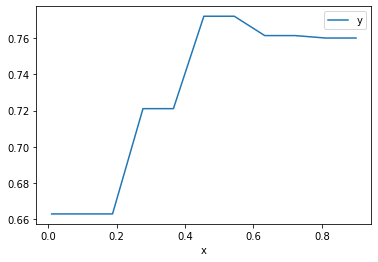

In [134]:
evaluate_majority(top_f1_binary[list(range(0,1208))][:15], y_test_bin)

/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

{'0': {'precision': 0.8738255033557047, 'recall': 0.7543453070683661, 'f1-score': 0.8097014925373135, 'support': 863}, '1': {'precision': 0.5526315789473685, 'recall': 0.3652173913043478, 'f1-score': 0.4397905759162304, 'support': 345}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.6432119205298014, 'macro avg': {'precision': 0.4754856941010244, 'recall': 0.37318756612423803, 'f1-score': 0.4164973561511813, 'support': 1208}, 'weighted avg': {'precision': 0.7820937948119332, 'recall': 0.6432119205298014, 'f1-score': 0.704056404595034, 'support': 1208}}
{'0': {'precision': 0.8738255033557047, 'recall': 0.7543453070683661, 'f1-score': 0.8097014925373135, 'support': 863}, '1': {'precision': 0.5526315789473685, 'recall': 0.3652173913043478, 'f1-score': 0.4397905759162304, 'support': 345}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.6432119205298014, 'macro avg': {'precision': 0.4754856941010244, 'recall': 0.3731

/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

{'0': {'precision': 0.8738255033557047, 'recall': 0.7543453070683661, 'f1-score': 0.8097014925373135, 'support': 863}, '1': {'precision': 0.5526315789473685, 'recall': 0.3652173913043478, 'f1-score': 0.4397905759162304, 'support': 345}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.6432119205298014, 'macro avg': {'precision': 0.4754856941010244, 'recall': 0.37318756612423803, 'f1-score': 0.4164973561511813, 'support': 1208}, 'weighted avg': {'precision': 0.7820937948119332, 'recall': 0.6432119205298014, 'f1-score': 0.704056404595034, 'support': 1208}}
{'0': {'precision': 0.8536912751677852, 'recall': 0.7607655502392344, 'f1-score': 0.8045540796963946, 'support': 836}, '1': {'precision': 0.5833333333333334, 'recall': 0.3575268817204301, 'f1-score': 0.44333333333333336, 'support': 372}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.6365894039735099, 'macro avg': {'precision': 0.47900820283370615, 'recall': 0.37

/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

{'0': {'precision': 0.8536912751677852, 'recall': 0.7607655502392344, 'f1-score': 0.8045540796963946, 'support': 836}, '1': {'precision': 0.5833333333333334, 'recall': 0.3575268817204301, 'f1-score': 0.44333333333333336, 'support': 372}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.6365894039735099, 'macro avg': {'precision': 0.47900820283370615, 'recall': 0.37276414398655483, 'f1-score': 0.4159624710099093, 'support': 1208}, 'weighted avg': {'precision': 0.7704353526823414, 'recall': 0.6365894039735099, 'f1-score': 0.6933172273395579, 'support': 1208}}


/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

{'0': {'precision': 0.8389261744966443, 'recall': 0.7659313725490197, 'f1-score': 0.800768737988469, 'support': 816}, '1': {'precision': 0.6052631578947368, 'recall': 0.3520408163265306, 'f1-score': 0.4451612903225806, 'support': 392}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.6316225165562914, 'macro avg': {'precision': 0.4813964441304604, 'recall': 0.3726573962918501, 'f1-score': 0.41531000943701657, 'support': 1208}, 'weighted avg': {'precision': 0.7631017518907274, 'recall': 0.6316225165562914, 'f1-score': 0.6853729437127835, 'support': 1208}}


/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

{'0': {'precision': 0.8389261744966443, 'recall': 0.7659313725490197, 'f1-score': 0.800768737988469, 'support': 816}, '1': {'precision': 0.6052631578947368, 'recall': 0.3520408163265306, 'f1-score': 0.4451612903225806, 'support': 392}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.6316225165562914, 'macro avg': {'precision': 0.4813964441304604, 'recall': 0.3726573962918501, 'f1-score': 0.41531000943701657, 'support': 1208}, 'weighted avg': {'precision': 0.7631017518907274, 'recall': 0.6316225165562914, 'f1-score': 0.6853729437127835, 'support': 1208}}


/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

{'0': {'precision': 0.836241610738255, 'recall': 0.7729528535980149, 'f1-score': 0.8033526756931012, 'support': 806}, '1': {'precision': 0.6271929824561403, 'recall': 0.35572139303482586, 'f1-score': 0.45396825396825397, 'support': 402}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.6341059602649006, 'macro avg': {'precision': 0.4878115310647984, 'recall': 0.3762247488776136, 'f1-score': 0.4191069765537851, 'support': 1208}, 'weighted avg': {'precision': 0.7666741036443725, 'recall': 0.6341059602649006, 'f1-score': 0.6870840187946008, 'support': 1208}}


/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

{'0': {'precision': 0.836241610738255, 'recall': 0.7729528535980149, 'f1-score': 0.8033526756931012, 'support': 806}, '1': {'precision': 0.6271929824561403, 'recall': 0.35572139303482586, 'f1-score': 0.45396825396825397, 'support': 402}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.6341059602649006, 'macro avg': {'precision': 0.4878115310647984, 'recall': 0.3762247488776136, 'f1-score': 0.4191069765537851, 'support': 1208}, 'weighted avg': {'precision': 0.7666741036443725, 'recall': 0.6341059602649006, 'f1-score': 0.6870840187946008, 'support': 1208}}
{'0': {'precision': 0.8161073825503355, 'recall': 0.7824967824967825, 'f1-score': 0.7989487516425755, 'support': 777}, '1': {'precision': 0.6622807017543859, 'recall': 0.3503480278422274, 'f1-score': 0.4582701062215479, 'support': 431}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.6283112582781457, 'macro avg': {'precision': 0.4927960281015738, 'recall': 0.377

/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

{'0': {'precision': 0.8161073825503355, 'recall': 0.7824967824967825, 'f1-score': 0.7989487516425755, 'support': 777}, '1': {'precision': 0.6622807017543859, 'recall': 0.3503480278422274, 'f1-score': 0.4582701062215479, 'support': 431}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.6283112582781457, 'macro avg': {'precision': 0.4927960281015738, 'recall': 0.37761493677966995, 'f1-score': 0.4190729526213745, 'support': 1208}, 'weighted avg': {'precision': 0.7612238565378734, 'recall': 0.6283112582781457, 'f1-score': 0.6773986720262982, 'support': 1208}}


/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

,y,x
0,0.416497,0.010
1,0.416497,0.099
2,0.416497,0.188
3,0.415962,0.277
4,0.415962,0.366
5,0.415310,0.455
6,0.415310,0.544
7,0.419107,0.633
8,0.419107,0.722
9,0.419073,0.811


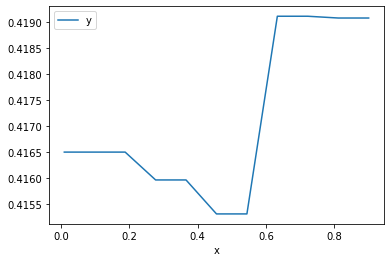

In [135]:
evaluate_majority(top_f1_ternary[list(range(0,1208))][:15], y_test_tern)

In [187]:

print(f"Vote Top 10 : {classification_report(disagreed_vote(top_f1_binary[list(range(0,1208))]), y_test_bin)}")
print(f" Top 1 : {classification_report(top_f1_binary[list(range(0,1208))].iloc[0], y_test_bin)}")

Vote Top 10 :               precision    recall  f1-score   support

           0       0.96      0.71      0.82      1009
           1       0.37      0.85      0.51       199

    accuracy                           0.73      1208
   macro avg       0.66      0.78      0.66      1208
weighted avg       0.86      0.73      0.77      1208

 Top 1 :               precision    recall  f1-score   support

           0       0.83      0.80      0.81       774
           1       0.66      0.70      0.68       434

    accuracy                           0.76      1208
   macro avg       0.74      0.75      0.75      1208
weighted avg       0.77      0.76      0.76      1208



In [137]:

print(f"Vote Top 10 : {classification_report(disagreed_vote(top_f1_ternary[list(range(0,1208))]), y_test_tern)}")
print(f" Top 1 : {classification_report(top_f1_ternary[list(range(0,1208))].iloc[0], y_test_tern)}")

Vote Top 10 :               precision    recall  f1-score   support

           0       0.87      0.75      0.81       863
           1       0.55      0.37      0.44       345
           2       0.00      0.00      0.00         0

    accuracy                           0.64      1208
   macro avg       0.48      0.37      0.42      1208
weighted avg       0.78      0.64      0.70      1208

 Top 1 :               precision    recall  f1-score   support

           0       0.85      0.77      0.81       818
           1       0.49      0.55      0.52       203
           2       0.41      0.51      0.45       187

    accuracy                           0.69      1208
   macro avg       0.58      0.61      0.59      1208
weighted avg       0.72      0.69      0.70      1208



/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ezequiellopez/_projects/UNED-PhD/src/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

##### Observations about the features


In [179]:
pd.DataFrame(classification_report(disagreed_vote(top_f1_binary[list(range(0,1208))]), y_test_bin, output_dict=True)).transpose().to_csv('voted_f1_binary_v1.csv')

In [172]:


pd.DataFrame(classification_report(top_f1_binary[list(range(0,1208))].iloc[0], y_test_bin,output_dict=True)).transpose().to_csv('top_f1_binary_v1.csv')



AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
#classification_report(top_f1_ternary[list(range(0,1208))].iloc[0], y_test_tern)

In [171]:

pd.DataFrame(classification_report(top_f1_ternary[list(range(0,1208))].iloc[0], y_test_tern, output_dict=True)).transpose().to_csv('top_f1_ternary_v1.csv')

#### top-10 doesn't work for ternary, based on macro f1 -> try by class 2 f1


In [138]:
data.X_train

,Unnamed: 0.1.1.1,use_case,doc_id,n_sentences,sentences,doc,tfidf_ready_sentence,metamap_feats,target,sentiment,agreed_labels
8,3044,Suprep-Bowel-Prep-Kit::Bowel-Preparation,47c14ccd-088d-4956-85e0-bec89db344ba,5,"very effective, but.....\r\n1st dose at 6pm da...","(very, effective, ,, but, ....., \r\n, 1st, do...","effective , ..... quantity dose quantity pm da...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,NON_RELATED
9,3045,Suprep-Bowel-Prep-Kit::Bowel-Preparation,47c14ccd-088d-4956-85e0-bec89db344ba,5,"uncomfortable abdominal distension by 7pm, nau...","(uncomfortable, abdominal, distension, by, 7, ...",uncomfortable abdominal distension quantity pm...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,attacking
10,3046,Suprep-Bowel-Prep-Kit::Bowel-Preparation,47c14ccd-088d-4956-85e0-bec89db344ba,5,movements did not start until 11:30pm and last...,"(movements, did, not, start, until, 11:30pm, a...",movement start 11:30pm last night ( quantity m...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,NON_RELATED
11,3047,Suprep-Bowel-Prep-Kit::Bowel-Preparation,47c14ccd-088d-4956-85e0-bec89db344ba,5,\r\nmy daily beverage of choice is water (+/-6...,"(\r\n, my, daily, beverage, of, choice, is, wa...","daily beverage choice water ( + /-64 oz ) , gr...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,attacking
12,3048,Suprep-Bowel-Prep-Kit::Bowel-Preparation,47c14ccd-088d-4956-85e0-bec89db344ba,5,\r\n** pharmacy advised not covered by insuran...,"(\r\n, *, *, pharmacy, advised, not, covered, ...",* * pharmacy advise cover insurance doctor off...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,NON_RELATED
...,...,...,...,...,...,...,...,...,...,...,...
6026,3022,Oseltamivir::Influenza,c2816ff2-0c05-4f9e-b162-4ca676eaaf13,5,i have stopped after 3 doses - awful diarrhea ...,"(i, have, stopped, after, 3, doses, -, awful, ...",stop quantity dose - awful diarrhea nausea .,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,attacking
6027,3023,Oseltamivir::Influenza,c2816ff2-0c05-4f9e-b162-4ca676eaaf13,5,i would rather let nature take its course than...,"(i, would, rather, let, nature, take, its, cou...",let nature course quantity hour .,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,NON_RELATED
6037,3033,Oseltamivir::Influenza,49d3a4cb-0802-4e6c-b19b-803af0974c44,3,i have had the flu twice now in the last 9 years.,"(i, have, had, the, flu, twice, now, in, the, ...",flu twice quantity year .,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,NON_RELATED
6038,3034,Oseltamivir::Influenza,49d3a4cb-0802-4e6c-b19b-803af0974c44,3,was given tamiflu each time.,"(was, given, tamiflu, each, time, .)",give tamiflu time .,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,NON_RELATED


In [139]:

top_accuracy_ternary = mat_ternary_results.sort_values(by=['accuracy'], ascending=False)[:top_n]
top_f1_ternary = mat_ternary_results.sort_values(by=['macro avg.f1-score'], ascending=False)[:top_n]

In [150]:
mat_ternary_results.columns[-30:]

Index([                    1200,                     1201,
                           1202,                     1203,
                           1204,                     1205,
                           1206,                     1207,
             'experiment_descr',            '0.precision',
                     '0.recall',             '0.f1-score',
                    '0.support',            '1.precision',
                     '1.recall',             '1.f1-score',
                    '1.support',            '2.precision',
                     '2.recall',             '2.f1-score',
                    '2.support',               'accuracy',
          'macro avg.precision',       'macro avg.recall',
           'macro avg.f1-score',      'macro avg.support',
       'weighted avg.precision',    'weighted avg.recall',
        'weighted avg.f1-score',   'weighted avg.support'],
      dtype='object')

In [151]:
mat_ternary_results.sort_values(by='2.f1-score', ascending=False)[['experiment_descr', 'macro avg.f1-score', '0.f1-score','1.f1-score','2.f1-score']][:10]

,experiment_descr,macro avg.f1-score,0.f1-score,1.f1-score,2.f1-score
16,experiment_2__model:RandomForest__context:Fals...,0.573067,0.810386,0.435262,0.473552
4,experiment_1__model:RandomForest__context:Fals...,0.568111,0.805843,0.427027,0.471464
120,experiment_12__model:LogisticRegression__conte...,0.571813,0.821114,0.437500,0.456825
132,experiment_13__model:SGDClassifier__context:Fa...,0.592067,0.806142,0.515081,0.454976
122,experiment_12__model:SGDClassifier__context:Fa...,0.590391,0.803560,0.514151,0.453461
39,experiment_4__model:SGDClassifier__context:Fal...,0.586921,0.806883,0.509434,0.444444
36,experiment_4__model:LogisticRegression__contex...,0.558999,0.816754,0.416422,0.443820
27,experiment_3__model:SGDClassifier__context:Fal...,0.575676,0.797436,0.487239,0.442353
98,experiment_10__model:LogisticRegression__conte...,0.566547,0.822703,0.436261,0.440678
24,experiment_3__model:LogisticRegression__contex...,0.557806,0.815376,0.418605,0.439437


In [153]:
mat_ternary_results.sort_values(by='1.f1-score', ascending=False)[['experiment_descr', 'macro avg.f1-score', '0.f1-score','1.f1-score','2.f1-score']][:10]

,experiment_descr,macro avg.f1-score,0.f1-score,1.f1-score,2.f1-score
100,experiment_10__model:SGDClassifier__context:Fa...,0.589048,0.801796,0.532407,0.432941
132,experiment_13__model:SGDClassifier__context:Fa...,0.592067,0.806142,0.515081,0.454976
122,experiment_12__model:SGDClassifier__context:Fa...,0.590391,0.803560,0.514151,0.453461
39,experiment_4__model:SGDClassifier__context:Fal...,0.586921,0.806883,0.509434,0.444444
70,experiment_7__model:SGDClassifier__context:Fal...,0.580976,0.799230,0.505910,0.437788
137,experiment_13__model:SGDClassifier__context:Tr...,0.545745,0.784578,0.489474,0.363184
27,experiment_3__model:SGDClassifier__context:Fal...,0.575676,0.797436,0.487239,0.442353
75,experiment_7__model:SGDClassifier__context:Tru...,0.539220,0.781481,0.484694,0.351485
127,experiment_12__model:SGDClassifier__context:Tr...,0.543336,0.782288,0.484536,0.363184
3,experiment_1__model:SGDClassifier__context:Fal...,0.559719,0.786990,0.480952,0.411215


##### Observation:
Configuration 132: experiment 13 SGD context False - seems to be the best one

In [158]:
mat_ternary_results.sort_values(by='1.f1-score', ascending=False)[['experiment_descr']][:10].values.tolist()

[['experiment_10__model:SGDClassifier__context:False__label_config:ternary'],
 ['experiment_13__model:SGDClassifier__context:False__label_config:ternary'],
 ['experiment_12__model:SGDClassifier__context:False__label_config:ternary'],
 ['experiment_4__model:SGDClassifier__context:False__label_config:ternary'],
 ['experiment_7__model:SGDClassifier__context:False__label_config:ternary'],
 ['experiment_13__model:SGDClassifier__context:True__label_config:ternary'],
 ['experiment_3__model:SGDClassifier__context:False__label_config:ternary'],
 ['experiment_7__model:SGDClassifier__context:True__label_config:ternary'],
 ['experiment_12__model:SGDClassifier__context:True__label_config:ternary'],
 ['experiment_1__model:SGDClassifier__context:False__label_config:ternary']]

In [159]:
mat_ternary_results.sort_values(by='2.f1-score', ascending=False)[['experiment_descr']][:10].values.tolist()

[['experiment_2__model:RandomForest__context:False__label_config:ternary'],
 ['experiment_1__model:RandomForest__context:False__label_config:ternary'],
 ['experiment_12__model:LogisticRegression__context:False__label_config:ternary'],
 ['experiment_13__model:SGDClassifier__context:False__label_config:ternary'],
 ['experiment_12__model:SGDClassifier__context:False__label_config:ternary'],
 ['experiment_4__model:SGDClassifier__context:False__label_config:ternary'],
 ['experiment_4__model:LogisticRegression__context:False__label_config:ternary'],
 ['experiment_3__model:SGDClassifier__context:False__label_config:ternary'],
 ['experiment_10__model:LogisticRegression__context:False__label_config:ternary'],
 ['experiment_3__model:LogisticRegression__context:False__label_config:ternary']]

In [163]:
pd.concat([data.X_train, data.X_test])

,Unnamed: 0.1.1.1,use_case,doc_id,n_sentences,sentences,doc,tfidf_ready_sentence,metamap_feats,target,sentiment,agreed_labels
8,3044,Suprep-Bowel-Prep-Kit::Bowel-Preparation,47c14ccd-088d-4956-85e0-bec89db344ba,5,"very effective, but.....\r\n1st dose at 6pm da...","(very, effective, ,, but, ....., \r\n, 1st, do...","effective , ..... quantity dose quantity pm da...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,NON_RELATED
9,3045,Suprep-Bowel-Prep-Kit::Bowel-Preparation,47c14ccd-088d-4956-85e0-bec89db344ba,5,"uncomfortable abdominal distension by 7pm, nau...","(uncomfortable, abdominal, distension, by, 7, ...",uncomfortable abdominal distension quantity pm...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,attacking
10,3046,Suprep-Bowel-Prep-Kit::Bowel-Preparation,47c14ccd-088d-4956-85e0-bec89db344ba,5,movements did not start until 11:30pm and last...,"(movements, did, not, start, until, 11:30pm, a...",movement start 11:30pm last night ( quantity m...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,NON_RELATED
11,3047,Suprep-Bowel-Prep-Kit::Bowel-Preparation,47c14ccd-088d-4956-85e0-bec89db344ba,5,\r\nmy daily beverage of choice is water (+/-6...,"(\r\n, my, daily, beverage, of, choice, is, wa...","daily beverage choice water ( + /-64 oz ) , gr...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,attacking
12,3048,Suprep-Bowel-Prep-Kit::Bowel-Preparation,47c14ccd-088d-4956-85e0-bec89db344ba,5,\r\n** pharmacy advised not covered by insuran...,"(\r\n, *, *, pharmacy, advised, not, covered, ...",* * pharmacy advise cover insurance doctor off...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,NON_RELATED
...,...,...,...,...,...,...,...,...,...,...,...
6032,3028,Oseltamivir::Influenza,a4fbfe6f-5a23-494b-acf6-de944ef35d8b,9,doc gave me prescription for tamiflu which i s...,"(doc, gave, me, prescription, for, tamiflu, wh...",doc give prescription tamiflu start right away .,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,NON_RELATED
6033,3029,Oseltamivir::Influenza,a4fbfe6f-5a23-494b-acf6-de944ef35d8b,9,i still stayed home from work monday and tuesd...,"(i, still, stayed, home, from, work, monday, a...",stay home work monday tuesday feel well wednes...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,0,supporting
6034,3030,Oseltamivir::Influenza,a4fbfe6f-5a23-494b-acf6-de944ef35d8b,9,did this help shorten the duration?,"( , did, this, help, shorten, the, duration, ?)",help shorten duration ?,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,NON_RELATED
6035,3031,Oseltamivir::Influenza,a4fbfe6f-5a23-494b-acf6-de944ef35d8b,9,not certain,"(not, certain)",certain,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,NON_RELATED


In [166]:
!pip3 install openpyxl

     |████████████████████████████████| 242 kB 523 kB/s            
You should consider upgrading via the '/Users/ezequiellopez/_projects/UNED-PhD/src/venv/bin/python -m pip install --upgrade pip' command.


In [168]:
## Get examples for all clases

data.X_train.sample(n=100)[['use_case','sentences', 'agreed_labels']].rename(columns={'use_case':'topic', 'sentences':'sentence', 'agreed_labels': 'label'})\
    .to_excel('sample_labeled_dataset.xlsx')

---

In [ ]:
reports_df = pd.DataFrame(flat_reports)
reports_df['experiment'] = list(experiments.keys())
reports_df['feats'] = [str(feat_list) for feat_list in experiments.values()]
reports_df.to_csv('ternary_reports_v1.csv')
reports_df

In [ ]:
data.X_test['y_experiment_'] = results[-1]

In [ ]:
data.X_test

-----

In [ ]:
feat_pipeline = data.run_feature_extraction(feature_config=experiments)

In [ ]:
X_train  = feat_pipeline.fit_transform(X=data.X_train)

In [ ]:
X_test = feat_pipeline.transform(data.X_test)


In [ ]:
data.run_classification('SVM', features={'train': X_train, 'test': X_test})

In [ ]:
from classifiers.classifiers import classical_models, param_grid
import numpy as np
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from time import time
from sklearn.pipeline import Pipeline

# run randomized search
n_iter_search = 20


model = "SVM"
clf = Pipeline([
    # ('tfidf', TfidfVectorizer()),
    (classical_models[model])
])
pipeline_param_grid = {**param_grid[model]}


random_search = RandomizedSearchCV(
    clf, param_distributions=pipeline_param_grid, n_iter=n_iter_search
)

start = time()
random_search.fit(X_train, data.y_train)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

report(random_search.cv_results_)

### Combine Results

###